In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive

/content/drive


In [3]:
%cd MyDrive

/content/drive/MyDrive


In [4]:
%cd YOLOXAI

/content/drive/MyDrive/YOLOXAI


In [5]:
import cv2
import numpy as np

In [6]:
obj_file = "coco.names.txt"
obj_classes = []
net_config = "yolov3.cfg"
net_weights = "yolov3.weights"
blob_size = 416
confidence_threshold = 0.25
nms_threshold = 0.3

In [7]:
with open(obj_file ,"rt") as f:
    obj_classes = f.read().rstrip("\n").split("\n")
print(obj_classes)
print(len(obj_classes))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


In [8]:
net = cv2.dnn.readNetFromDarknet(net_config, net_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/darknet/darknet_importer.cpp:217: error: (-212:Parsing error) Failed to parse NetParameter file: yolov3.weights in function 'readNetFromDarknet'


In [9]:
def findObjects(output, img):
    img_h, img_w, img_c = img.shape
    bboxes = []
    class_ids = []
    confidences = []

    for cell in output:
        for detect_vector in cell:
            scores = detect_vector[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                w,h = int(detect_vector[2] * img_w), int(detect_vector[3] * img_h)
                x,y = int((detect_vector[0] * img_w) - w/2), int((detect_vector[1] * img_h) - h/2)
                bboxes.append([x,y,w,h])
                class_ids.append(class_id)
                confidences.append(float(confidence))
    indices = cv2.dnn.NMSBoxes(bboxes, confidences, confidence_threshold, nms_threshold)
    print(indices)
    for i in indices:
        #i = i[0]
        bbox = bboxes[i]
        x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, f'{obj_classes[class_ids[i]].upper()} {int(confidences[i] * 100)}%',
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

In [10]:
frame = cv2.imread('test2.jpg')
blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255, size=(blob_size,blob_size),mean=(0,0,0)
                             ,swapRB=True,crop=False)

In [11]:
net.setInput(blob)
out_names = net.getUnconnectedOutLayersNames()
output = net.forward(out_names)

findObjects(output, frame)


NameError: name 'net' is not defined

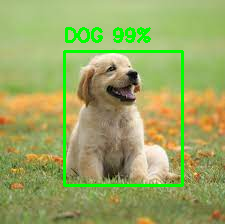

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(frame)
k = cv2.waitKey(0) & 0xFF
if k == 27:         # wait for ESC key to exit
    cv2.destroyAllWindows()

Explainable Object detection

In [ ]:
!pip install grad_cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad_cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=df0536498e858d34d78d250e28d4f9639cc0d7ec31b60302b569c8090b0cc9c0
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad_cam


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

In [ ]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

In [ ]:
img = cv2.imread('test6.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.0 MB/s eta 0:00:00

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-4-8 Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


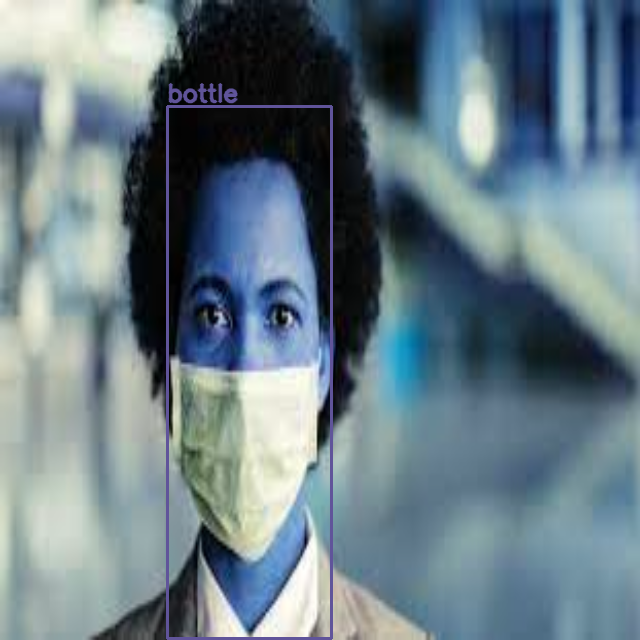

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

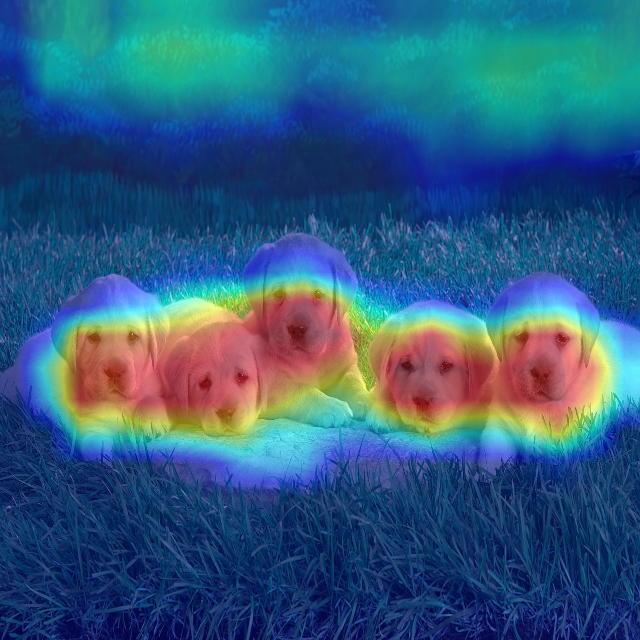

In [ ]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

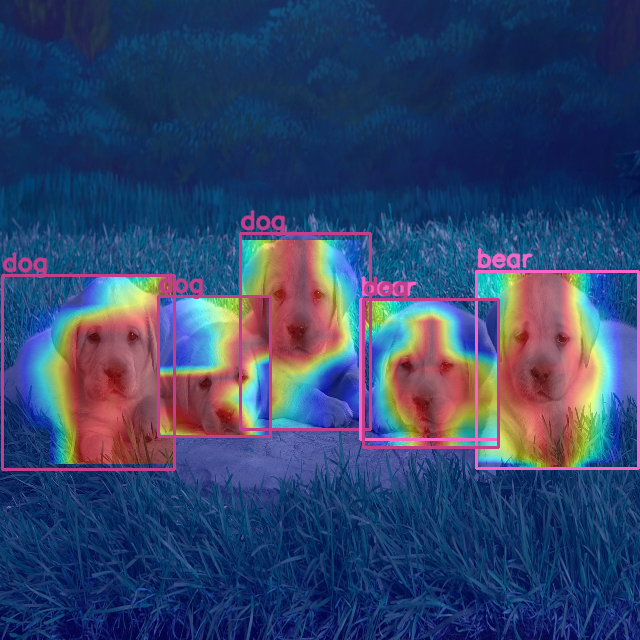

In [ ]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)